In [1]:
# IPython magic tools
%load_ext autoreload
%autoreload 2

# Standard library imports
import os
from os import PathLike
import subprocess
from pathlib import Path
from io import BytesIO
from datetime import datetime
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use a non-GUI backend

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import seaborn as sns
import cv2
import pytz
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display

# Custom library imports
from aind_vr_foraging_analysis.utils.parsing import parse, data_access

# Pandas & warning config
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Seaborn context
sns.set_context("talk")

# Color definitions
color1 = '#d95f02'
color2 = '#1b9e77'
color3 = '#7570b3'
color4 = 'yellow'
odor_list_color = [color1, color2, color3, color4]

color_dict_label = {
    'InterSite': '#808080',
    'InterPatch': '#b3b3b3', 
    'PatchZA': '#d95f02', 'PatchZB': '#d95f02', 
    'PatchB': '#d95f02', 'PatchA': '#7570b3', 
    'PatchC': '#1b9e77',
    'Alpha-pinene': '#1b9e77', 
    'Methyl Butyrate': '#7570b3', 
    'Amyl Acetate': '#d95f02', 
    'Fenchone': '#7570b3', 
    'S': color1,
    'D': color2,
    'N': color3,
}

label_dict = {
    **{"InterSite": '#808080', "InterPatch": '#b3b3b3'}, 
    **color_dict_label
}

# Function to assign codes
def get_condition_code(text):
    if 'delayed' in text:
        return 'D'
    elif 'single' in text:
        return 'S'
    elif 'no_reward' in text or 'noreward' in text:
        return 'N'
    elif 'double' in text:
        return 'Do'
    else:
        return text

# File paths
pdf_path = r'\\allen\aind\scratch\vr-foraging\sessions'
# foraging_figures = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents'
foraging_figures = r'C:\Users\jason.lee\OneDrive - Allen Institute\Documents\patch_foraging'


In [2]:
mouse_list = ["781896","781898", "788641"]

session_paths = data_access.find_sessions_relative_to_date(
    mouse = "781896",
    date_string = "2025-6-13",
    when = 'on',
    end_date_string = "2025-7-01"
)


all_epochs, stream_data, data = data_access.load_session(
    session_paths[0]
)

all_epochs['patch_label'] = all_epochs['patch_label'].apply(get_condition_code)
# all epochs gives you a trial-based table segmented by interpatch, intersite or odorsite. Stream_data gives access to continuous data parsed for interpretability. 

In [ ]:
data['harp_sniffsensor'].streams.DeviceName.load_from_file()
data['harp_sniffsensor'].streams.DeviceName.data

In [ ]:
all_epochs[(all_epochs['is_reward']==False) & (all_epochs['is_choice']==True)]

In [ ]:
all_epochs.groupby('patch_label')['is_reward'].mean()

In [ ]:
stream_data.give_reward

Output()

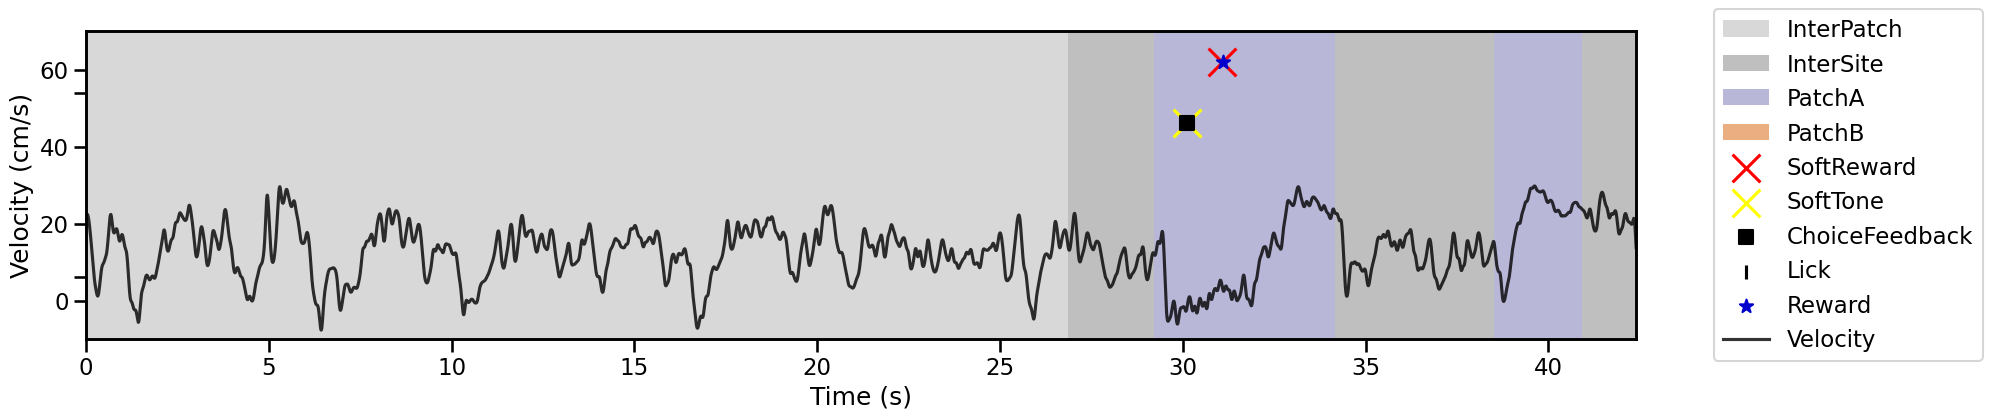

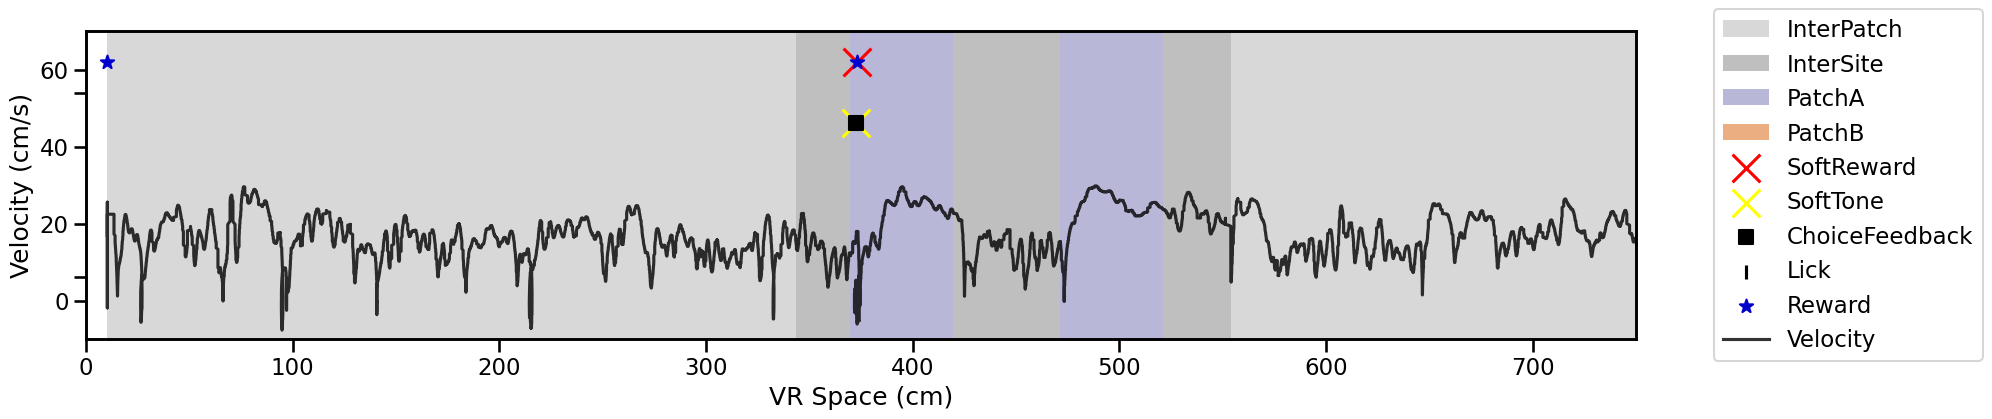

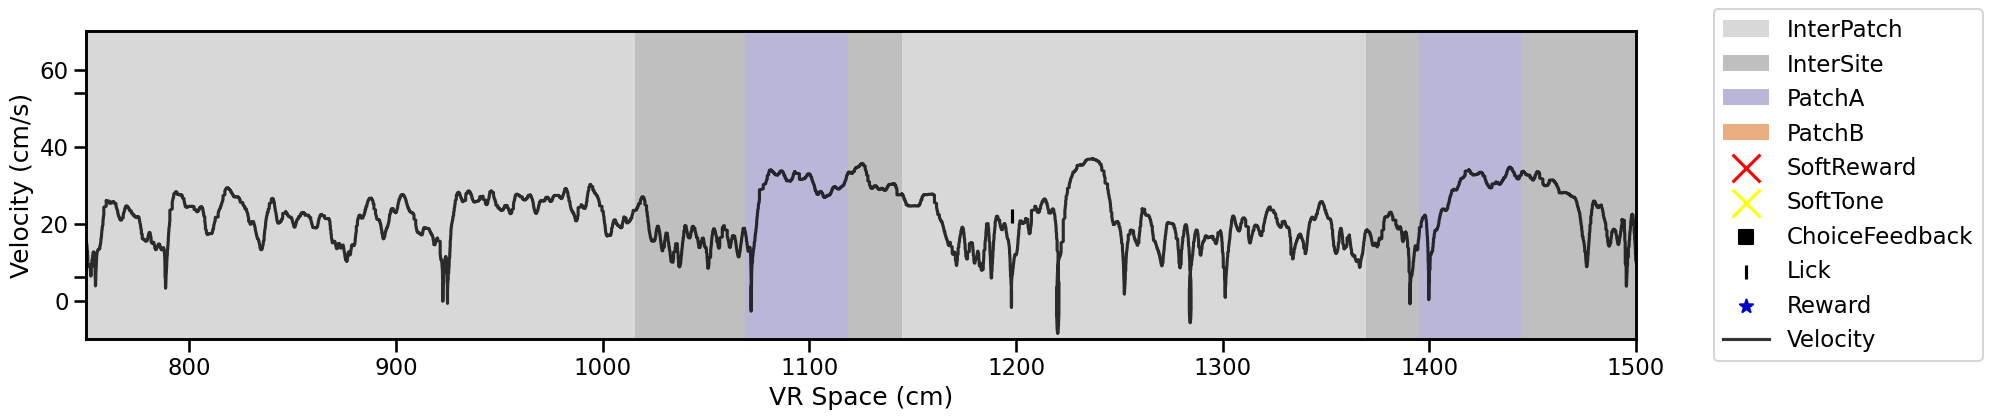

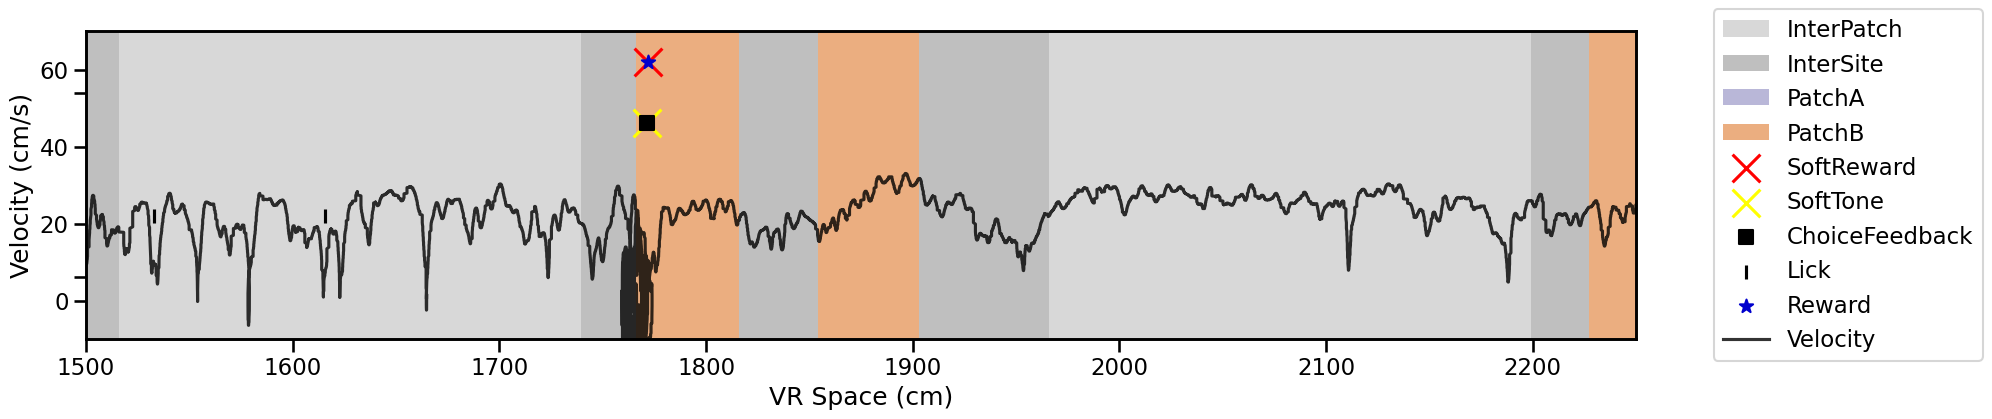

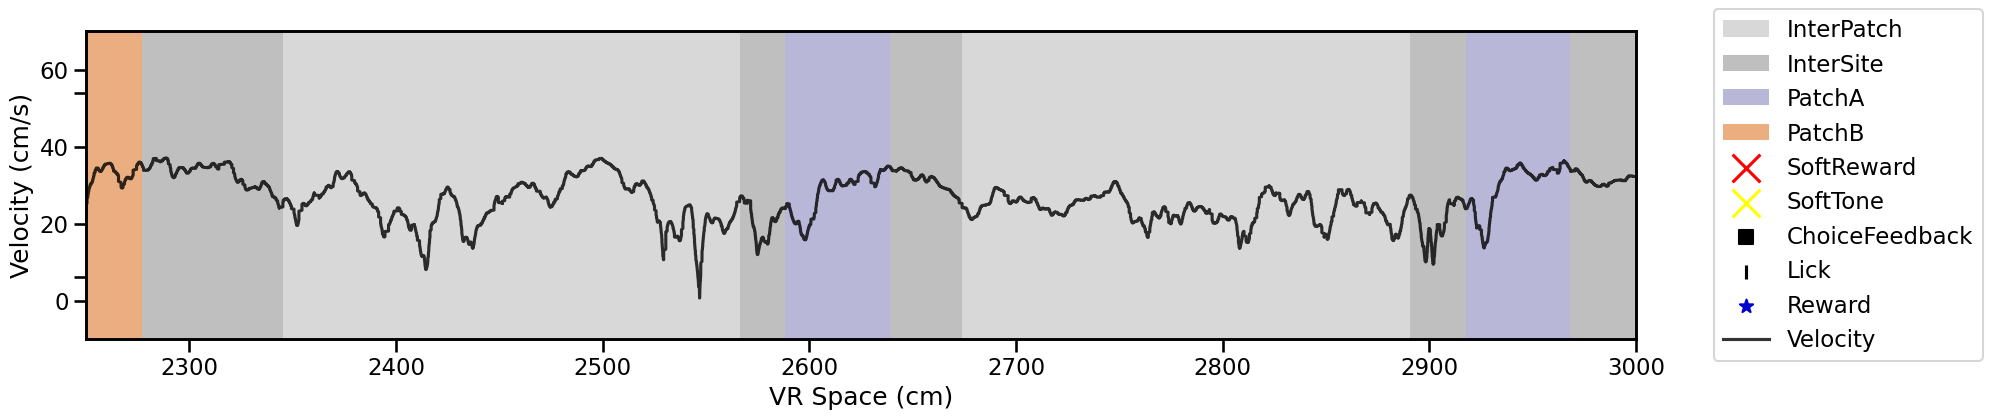

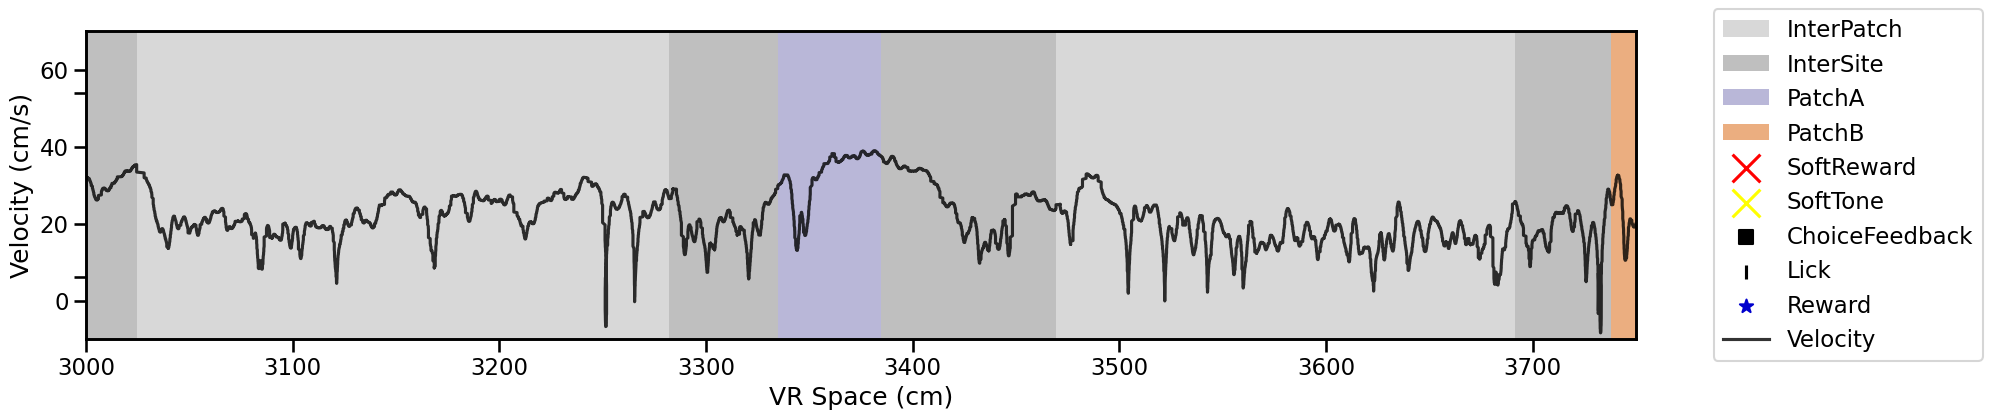

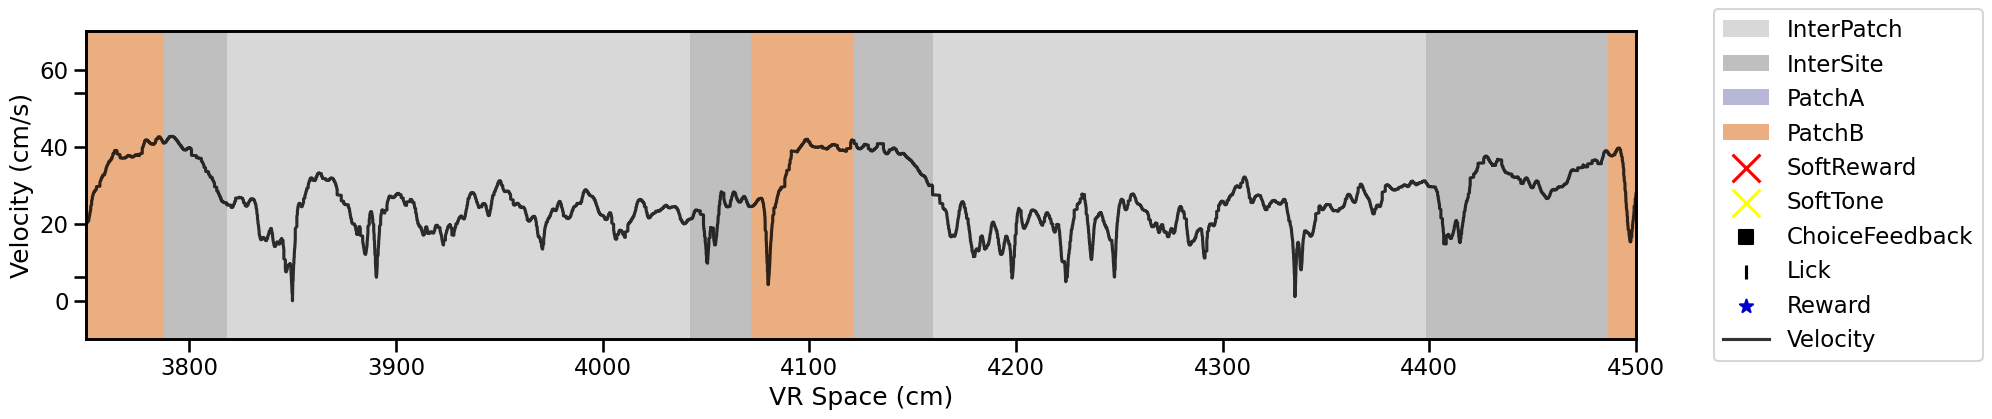

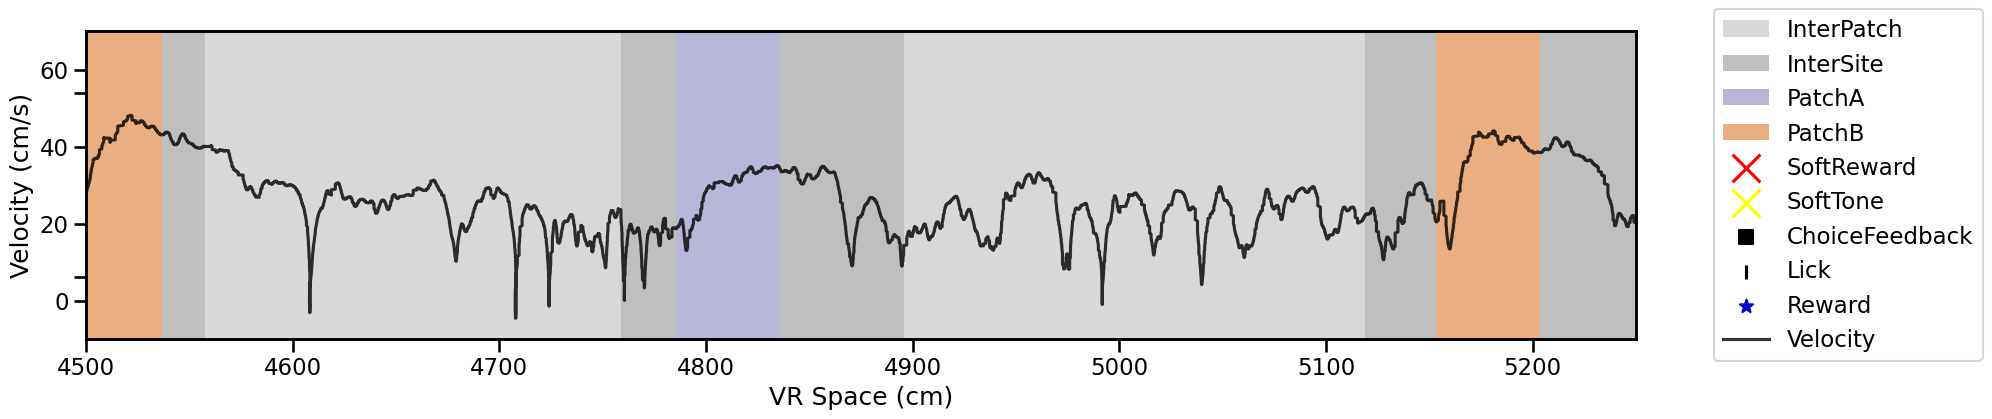

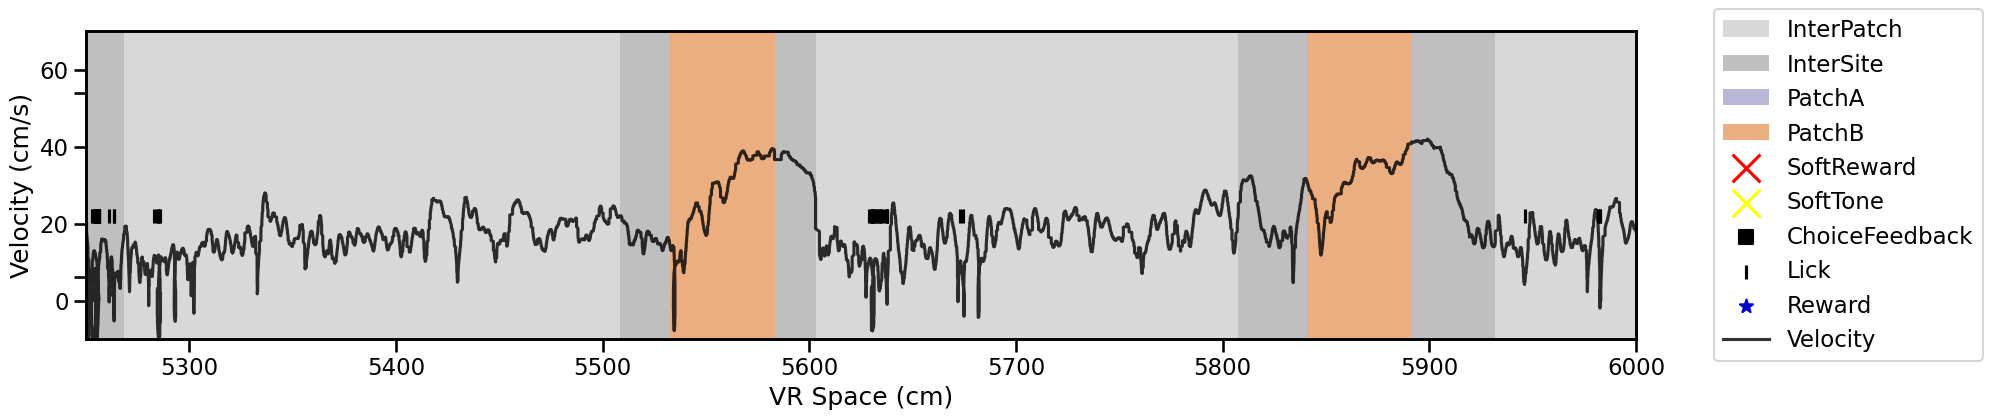

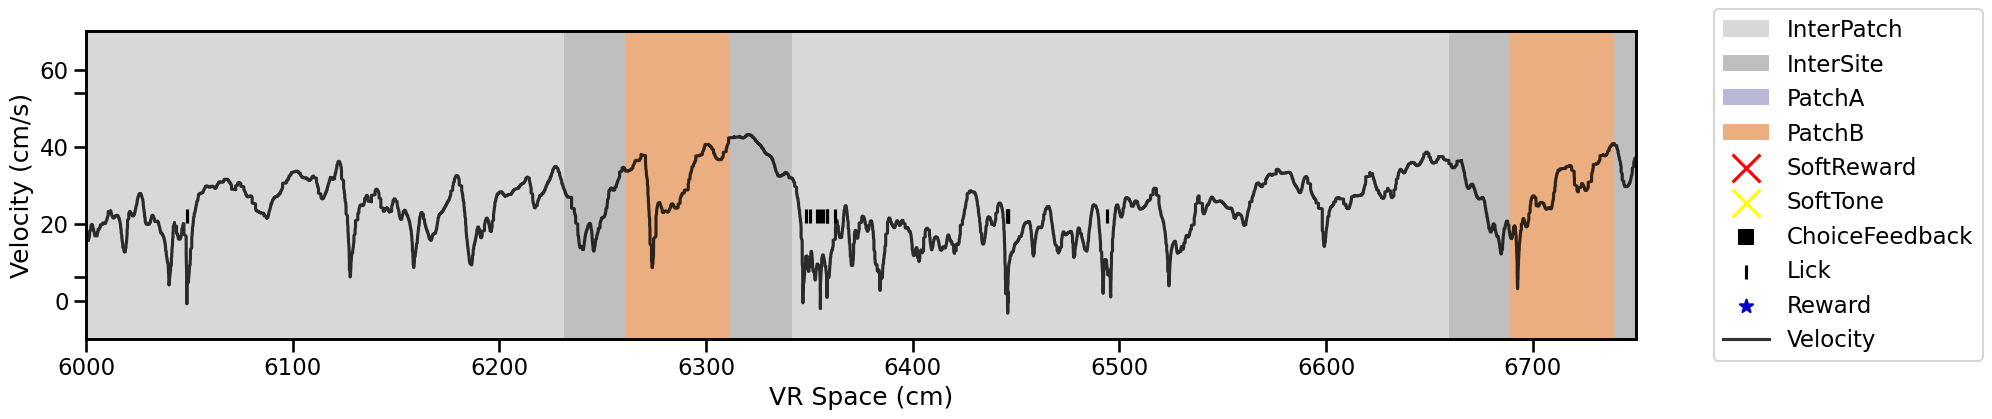

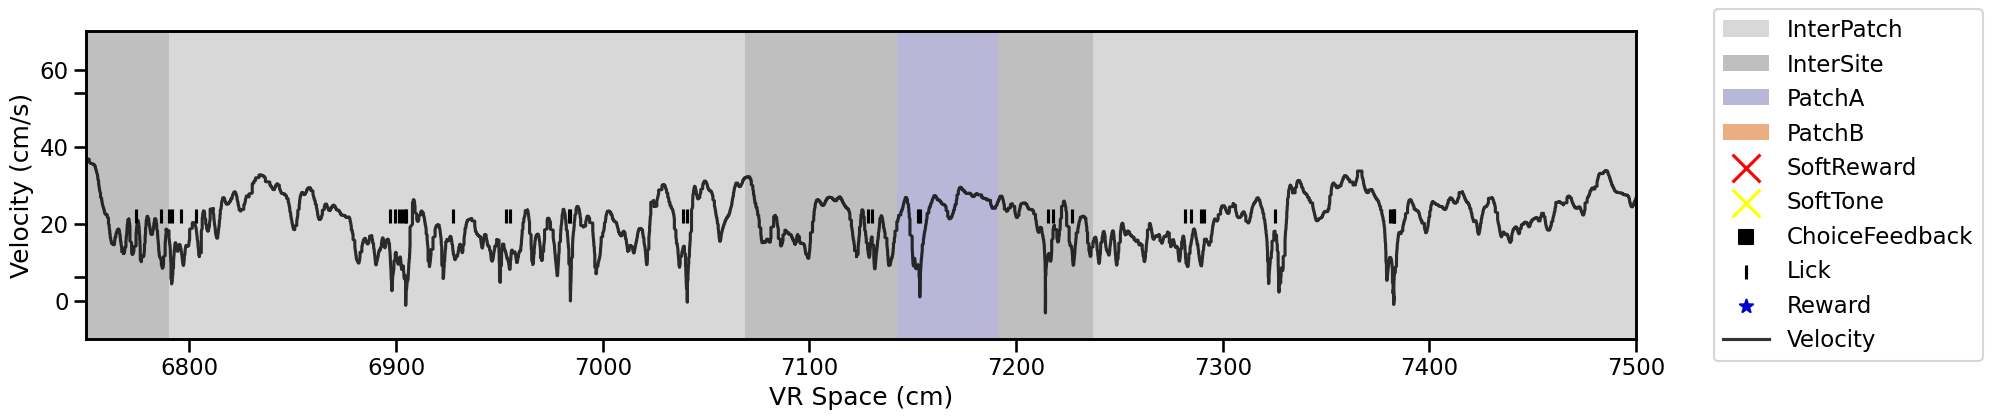

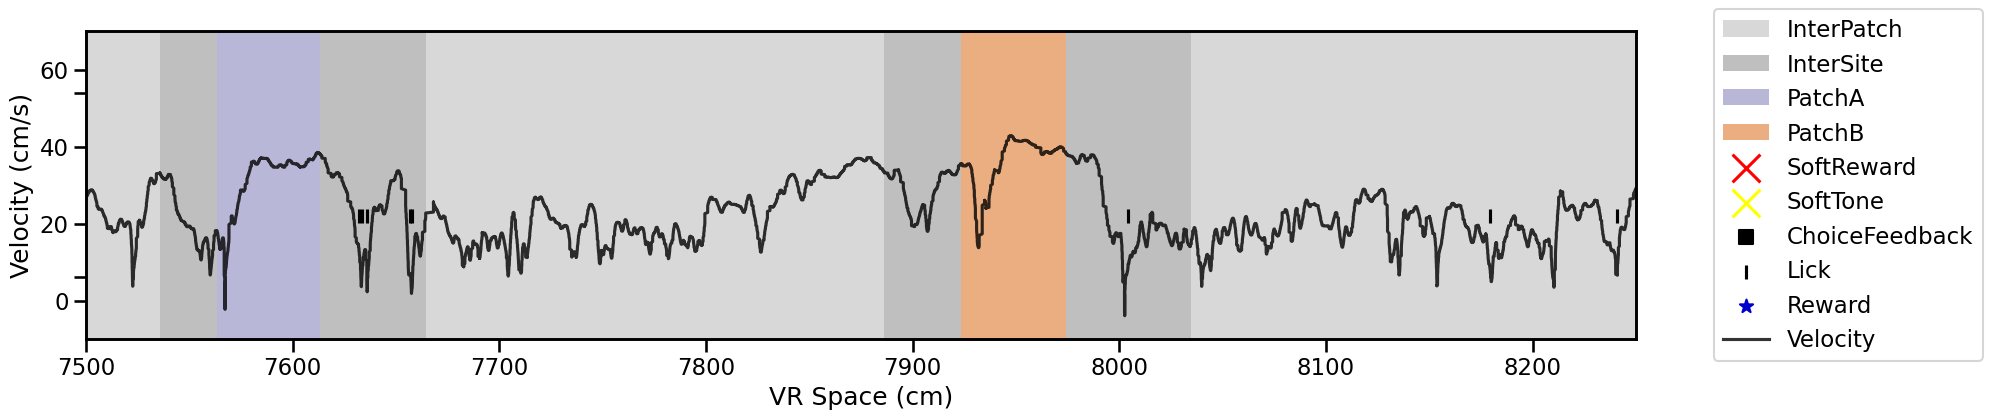

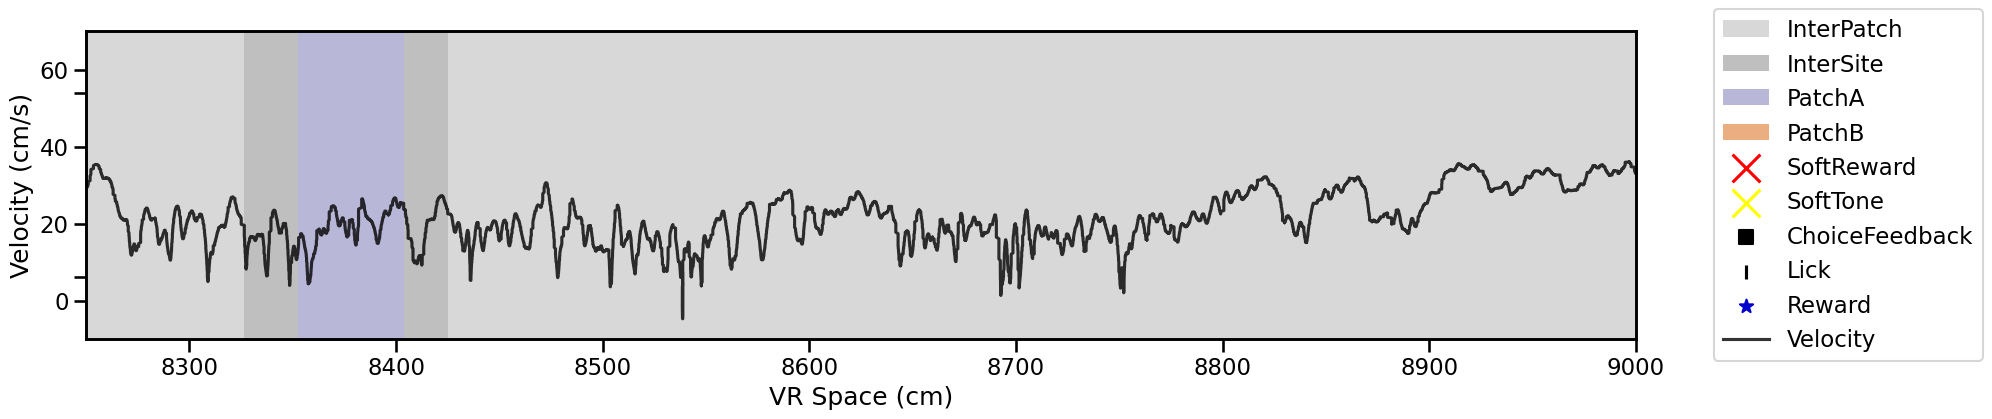

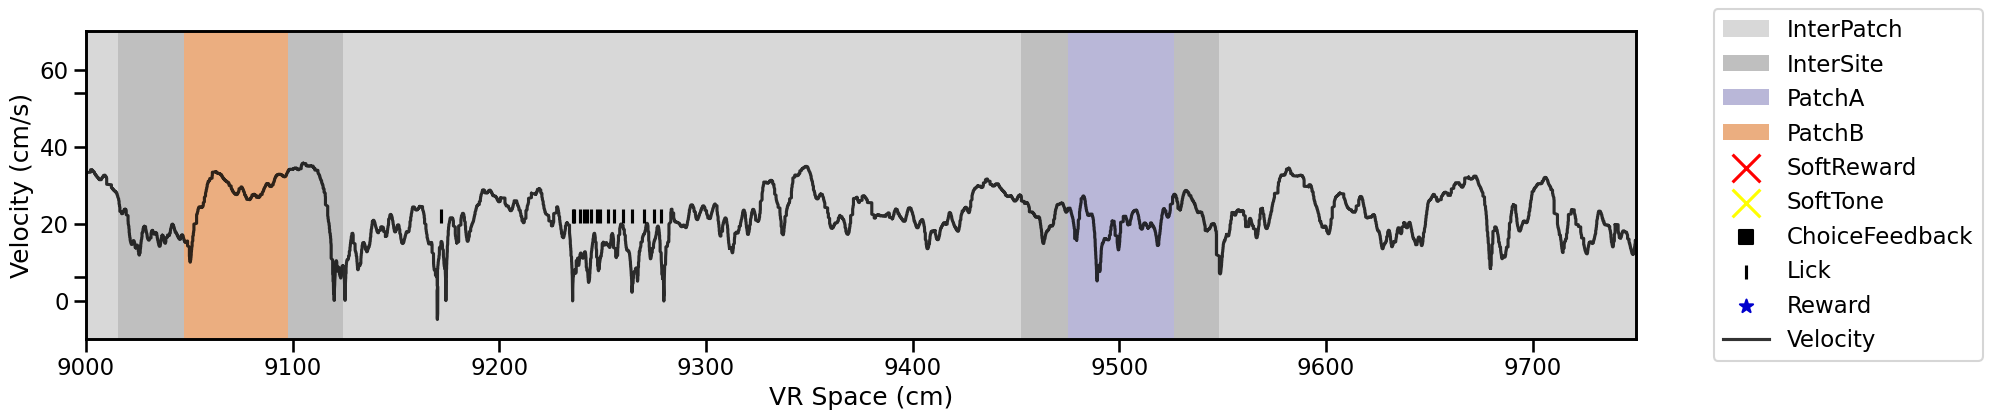

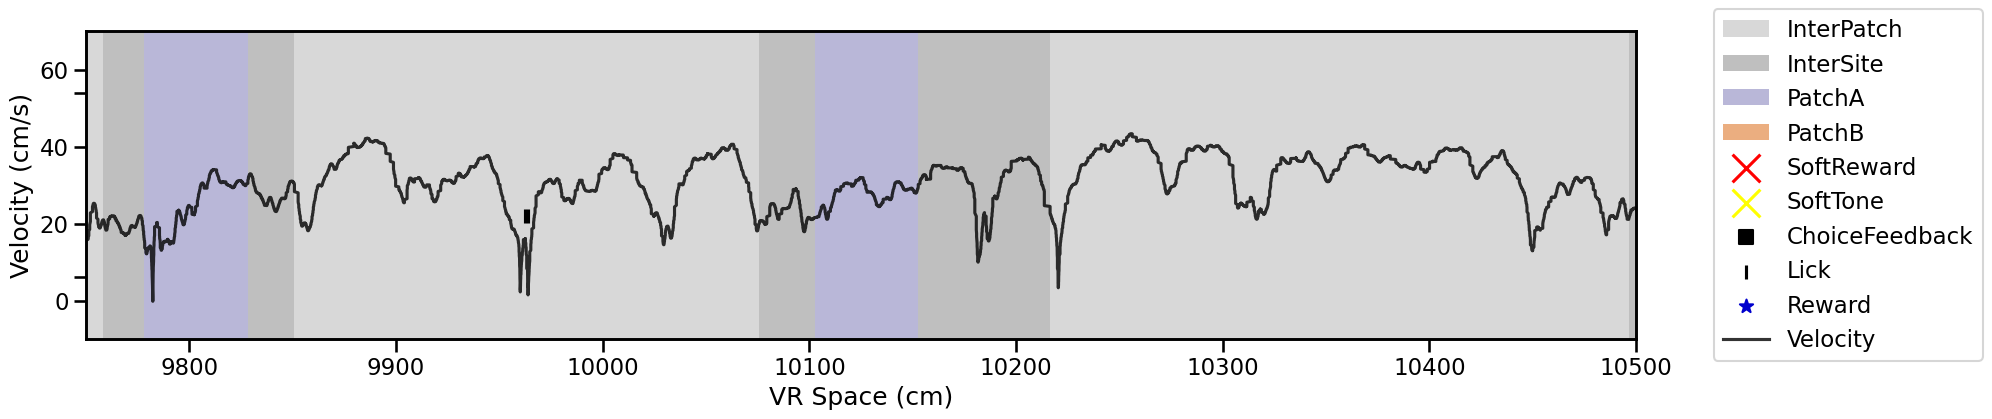

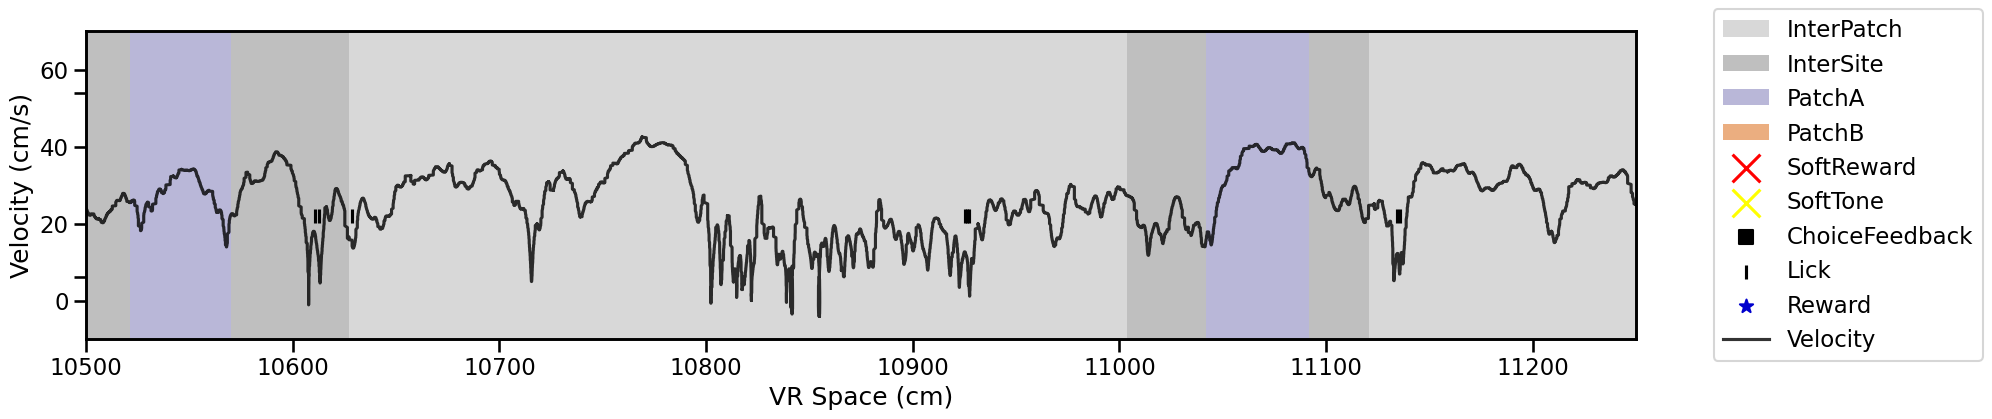

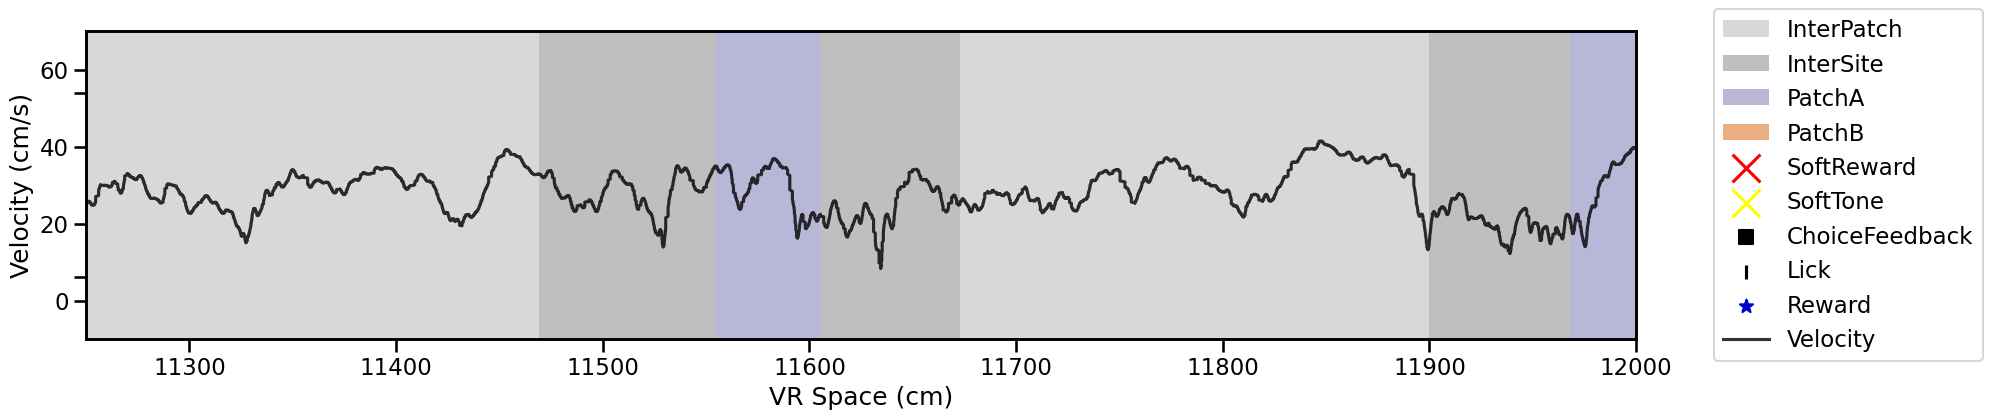

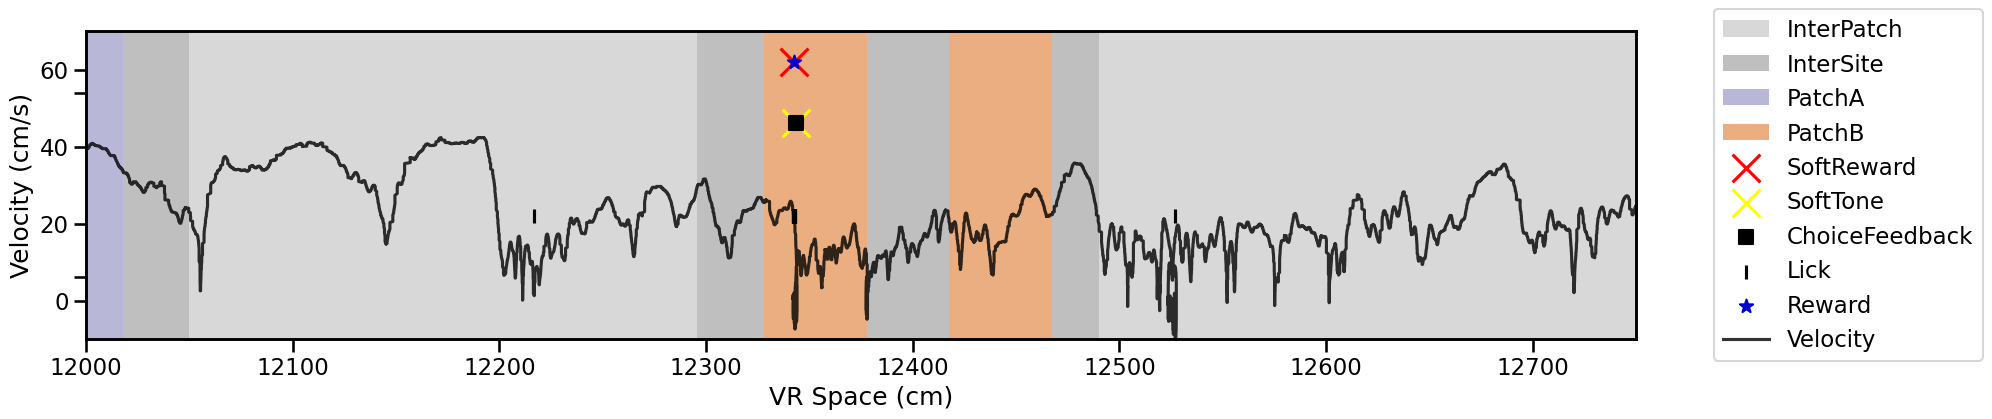

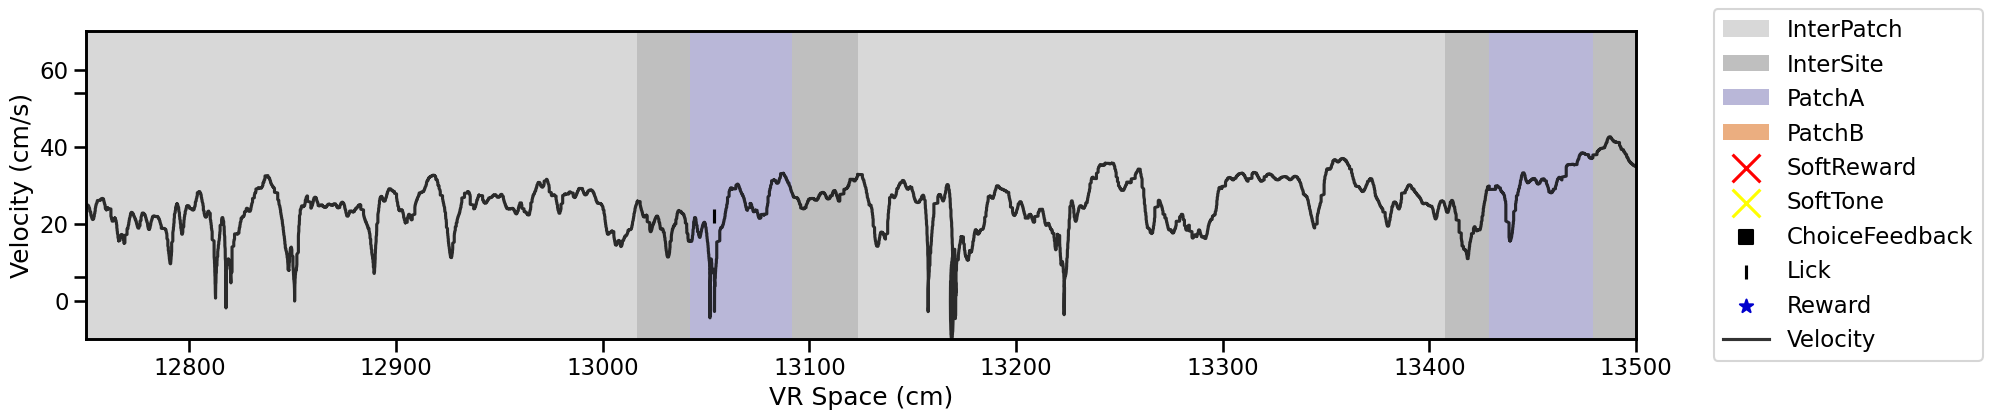

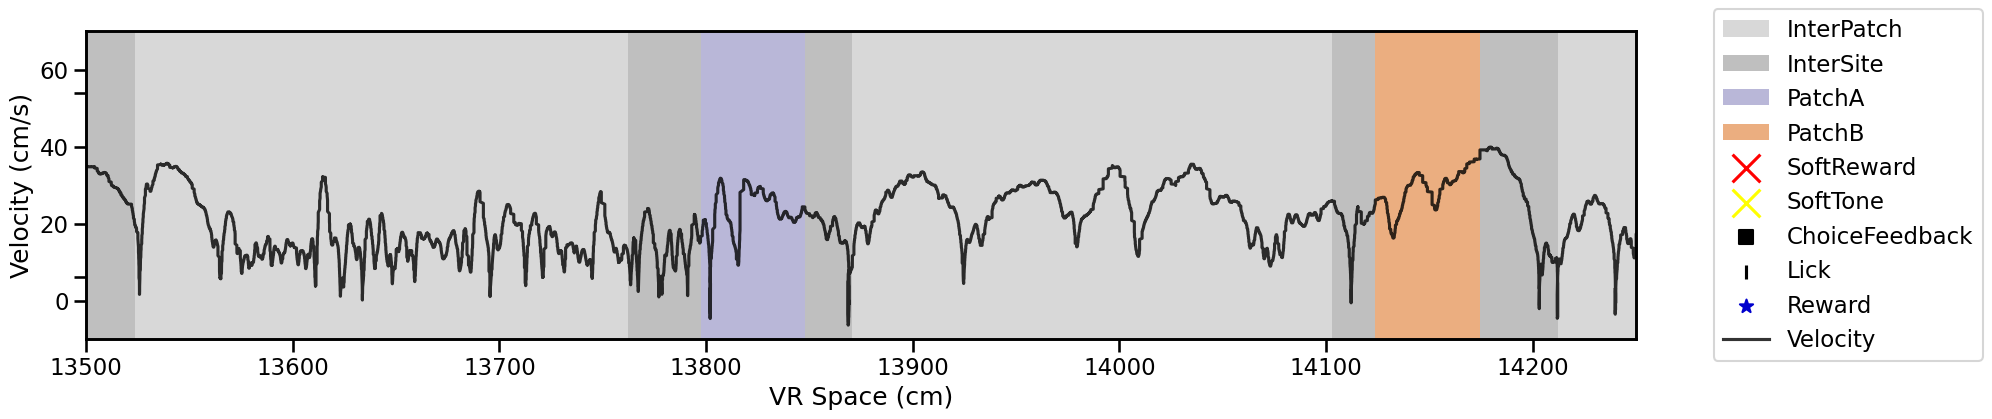

In [3]:
%matplotlib inline 
def add_position(df: pd.DataFrame, position:  pd.DataFrame):
    position.rename_axis('Time', axis='index', inplace=True)
    df.rename_axis('Time', axis='index', inplace=True)

    df = pd.merge_asof(df.sort_index(), position.sort_index(), direction='nearest', on="Time").set_index("Time").sort_index()
    df.columns = [*df.columns[:-1], 'Position']
    return df

def plot_patches(ax, navigation_mode, zero_index, _legend):
    """Plot the context patches based on the navigation mode."""
    _sites = add_position(all_epochs, position=stream_data.position_data)
    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index'] + 1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        if navigation_mode == "space":
            position = _sites["Position"].values[idx]
            width = _sites["Position"].values[idx + 1] - position
            p = Rectangle((position, -2), width, 8, linewidth=0, facecolor=facecolor, alpha=0.5)
        else:
            time_position = all_epochs.index[idx] - zero_index
            width = all_epochs.index[idx + 1] - all_epochs.index[idx]
            p = Rectangle((time_position, -2), width, 8, linewidth=0, facecolor=facecolor, alpha=0.5)

        _legend[site_label] = p
        ax.add_patch(p)

def plot_behavioral_events(ax, navigation_mode,  zero_index, _legend):
    """
    Plot the behavioral events based on the selected navigation mode.
    """
    events = [
        ("SoftReward", data['software_events'].streams['GiveReward'].data, 3.5, 'red', 'x', 400),
        ("SoftTone", data['software_events'].streams['ChoiceFeedback'].data, 2.5, 'yellow', 'x', 400),
        ('ChoiceFeedback', stream_data.choice_feedback, 2.5, 'k', 's', 100),
        ('Lick', stream_data.lick_onset, 1, 'k', '|', 100),
        ('Reward', stream_data.give_reward, 3.5, 'mediumblue', '*',100),
       
    ]
    
    # _legend["Waits"] = axs.scatter(stream_data.succesfull_wait.index - zero_index,
    #     succesfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    
    # _legend["Odor_on"] = axs.scatter(odor_triggers.odor_onset - zero_index,
    #     odor_triggers.odor_onset*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_triggers.odor_offset - zero_index,
    #     odor_triggers.odor_offset*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    for event_name, event_data, y_pos, color, marker, size in events:
        if navigation_mode == "time" or navigation_mode == "patch":
            # Plot events by time index
            _legend[event_name] = ax.scatter(event_data.index-zero_index, [y_pos] * len(event_data.index), label=event_name, color=color, marker=marker, s=size)
        else:
            # Plot events by position (space or patch mode)
            positions = add_position(event_data, stream_data.position_data)['Position'].values
            _legend[event_name] = ax.scatter(positions, [y_pos] * len(positions), label=event_name, color=color, marker=marker, s=size)
            
# Define a dictionary to map navigation modes to corresponding limits and increments
nav_config = {
    "patch": {"increment": 1},  # For patches, we move one patch at a time
    "time": {"increment": 30},
    "space": {"increment": 750}
}

def update_plot(x_start, navigation_mode="time"):
    """
    Update the plot based on the selected navigation mode (space, time, or patch).
    
    Parameters:
    ----------
    x_start : float
        The starting value for the x-axis (time or position or patch number).
    navigation_mode : str
        Mode of navigation: 'patch', 'time', or 'space'.
    """
    zero_index = all_epochs.index[0]
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(20, 4))
    
    # Get the configuration for the selected navigation mode
    nav_mode = nav_config.get(navigation_mode, nav_config["time"])  # Default to 'time' if mode is invalid
    
    if navigation_mode == "patch":
        # Get the start and end times of patches
        patch_start_times = all_epochs.loc[all_epochs['label'] == 'InterPatch'].index
        patch_end_times = patch_start_times[1:].append(pd.Index([all_epochs.index[-1]]))  # Next patch's start time as end time for the last one
        patches = list(zip(patch_start_times, patch_end_times))

        # Determine the current patch
        current_patch = int(x_start)  # Use the integer part of x_start as the patch index
        start, end = patches[current_patch]

        # Set the x-limits for the current patch
        ax.set_xlim(start - zero_index, end - zero_index)
        
    else:
        # Use the configured x-limits for time or space navigation
        ax.set_xlim(x_start, x_start + nav_mode.get("increment"))

    _legend = {}
    
    # Plot context patches (the "OdorSite", "InterPatch" regions)
    plot_patches(ax, navigation_mode, zero_index, _legend)
    
    # Plot behavioral events (e.g., ChoiceFeedback, Lick, ValveOpen)
    plot_behavioral_events(ax, navigation_mode,zero_index, _legend)
    
    # Plot the velocity curve
    ax2 = ax.twinx()
    if navigation_mode == "time" or navigation_mode == "patch":
        _legend["Velocity"] = ax2.plot(
            stream_data.encoder_data.index - zero_index,
            stream_data.encoder_data.filtered_velocity,
            c="k", label="Velocity", alpha=0.8
        )[0]
    else:
        _legend["Velocity"] = ax2.plot(add_position(stream_data.encoder_data.filtered_velocity, position=stream_data.position_data)["Position"].values, 
                                       stream_data.encoder_data.filtered_velocity.values, c="k", label="Encoder", alpha = 0.8)[0]
    
    
    # Customize axis labels, limits, and grid
    ax.set_yticklabels([])
    ax.set_yticks([])
    
    ax.set_xlabel("Time (s)" if navigation_mode != "space" else "VR Space (cm)")
    ax2.set_ylabel("Velocity (cm/s)")
    ax.set_ylim(bottom=-1, top=4)
    ax.set_yticks([0, 3])
    ax2.yaxis.tick_left()  # Move the ticks to the left side
    ax2.yaxis.set_label_position("left")  # Place the label on the left side
    ax.grid(False)
    ax2.set_ylim((-10, 70))
    ax.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
    
    return fig

# Define callback functions for the arrow buttons with different navigation logic based on the plot type
def on_left_button_clicked(button):
    # Adjust the x_start based on the selected navigation mode
    if navigation_mode_widget.value == "patch":
        x_start_widget.value -= 1  # Go to the previous patch
    else:
        x_start_widget.value -= nav_config[navigation_mode_widget.value]["increment"]  # Go left by increment

def on_right_button_clicked(button):
    # Adjust the x_start based on the selected navigation mode
    if navigation_mode_widget.value == "patch":
        x_start_widget.value += 1  # Go to the next patch
    else:
        x_start_widget.value += nav_config[navigation_mode_widget.value]["increment"]  # Go right by increment

def save_plot(button):
    fig, ax = update_plot(x_start_widget.value)  # Get the current plot
    save_name = "current_plot.png"  # Define the filename (you can modify this as needed)
    
    fig.savefig(save_name, bbox_inches='tight', pad_inches=0.1, transparent=True)
    print(f"Plot saved as {save_name}")

    
# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Create Save button
save_button = widgets.Button(description='Save Plot')

# Set the save button click event handler
save_button.on_click(save_plot)

# Define widget for the starting value of x-axis (space, time, or patch number)
x_start_widget = widgets.FloatText(value=0.0, description='X start:', continuous_update=False)

# Dropdown to select navigation mode (Space, Time, Patch)
navigation_mode_widget = widgets.Dropdown(
    options=['time', 'space','patch'],
    value='patch',
    description='Nav Mode:',
    disabled=False
)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button, navigation_mode_widget, save_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget, 'navigation_mode': navigation_mode_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)